In [1155]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import sklearn as sk
import copy
import seaborn as sns


print("Pandas: ", pd.__version__)
print("Numpy: ", np.__version__)
print("Sklearn: ", sk.__version__)

Pandas:  1.3.4
Numpy:  1.20.3
Sklearn:  1.1.1


# Trying to predict customer retention for telecom service using this dataset

Dataset: https://www.kaggle.com/datasets/barun2104/telecom-churn

- We will try to understand that what are the factors most affecting the retention of customers for their telephone service (i.e the customer churn).
- Who are the customers more likely to churn?
- What are the relations between some of the variables.!
- What actions can be taken to stop them from leaving?

# We will also be studying some of the major classification algorithms and try to optimize them for this dataset. We would also try to understand which ones are working better and why-
1. Logistic regression
2. K-Nearest neighbours
3. Decision Tree
4. Random Forest

In [1156]:
df= pd.read_csv("telecom_churn.csv")
df.head(10)

Churn  AccountWeeks  ContractRenewal  DataPlan  DataUsage  CustServCalls  \
0      0           128                1         1       2.70              1   
1      0           107                1         1       3.70              1   
2      0           137                1         0       0.00              0   
3      0            84                0         0       0.00              2   
4      0            75                0         0       0.00              3   
5      0           118                0         0       0.00              0   
6      0           121                1         1       2.03              3   
7      0           147                0         0       0.00              0   
8      0           117                1         0       0.19              1   
9      0           141                0         1       3.02              0   

   DayMins  DayCalls  MonthlyCharge  OverageFee  RoamMins  
0    265.1       110           89.0        9.87      10.0  
1    161.6       123           82.0        9.78      13.7  
2    243.4       114           52.0        6.06      12.2  
3    299.4        71           57.0        3.10       6.6  
4    166.7       113           41.0        7.42      10.1  
5    223.4        98           57.0       11.03       6.3  
6    218.2        88           87.3       17.43       7.5  
7    157.0        79           36.0        5.16       7.1  
8    184.5        97           63.9       17.58       8.7  
9    258.6        84           93.2       11.10      11.2

In [1157]:
df.shape

(3333, 11)

In [1158]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Churn            3333 non-null   int64  
 1   AccountWeeks     3333 non-null   int64  
 2   ContractRenewal  3333 non-null   int64  
 3   DataPlan         3333 non-null   int64  
 4   DataUsage        3333 non-null   float64
 5   CustServCalls    3333 non-null   int64  
 6   DayMins          3333 non-null   float64
 7   DayCalls         3333 non-null   int64  
 8   MonthlyCharge    3333 non-null   float64
 9   OverageFee       3333 non-null   float64
 10  RoamMins         3333 non-null   float64
dtypes: float64(5), int64(6)
memory usage: 286.6 KB


### We have no Null Values

In [1159]:
df.isnull().sum()

Churn              0
AccountWeeks       0
ContractRenewal    0
DataPlan           0
DataUsage          0
CustServCalls      0
DayMins            0
DayCalls           0
MonthlyCharge      0
OverageFee         0
RoamMins           0
dtype: int64

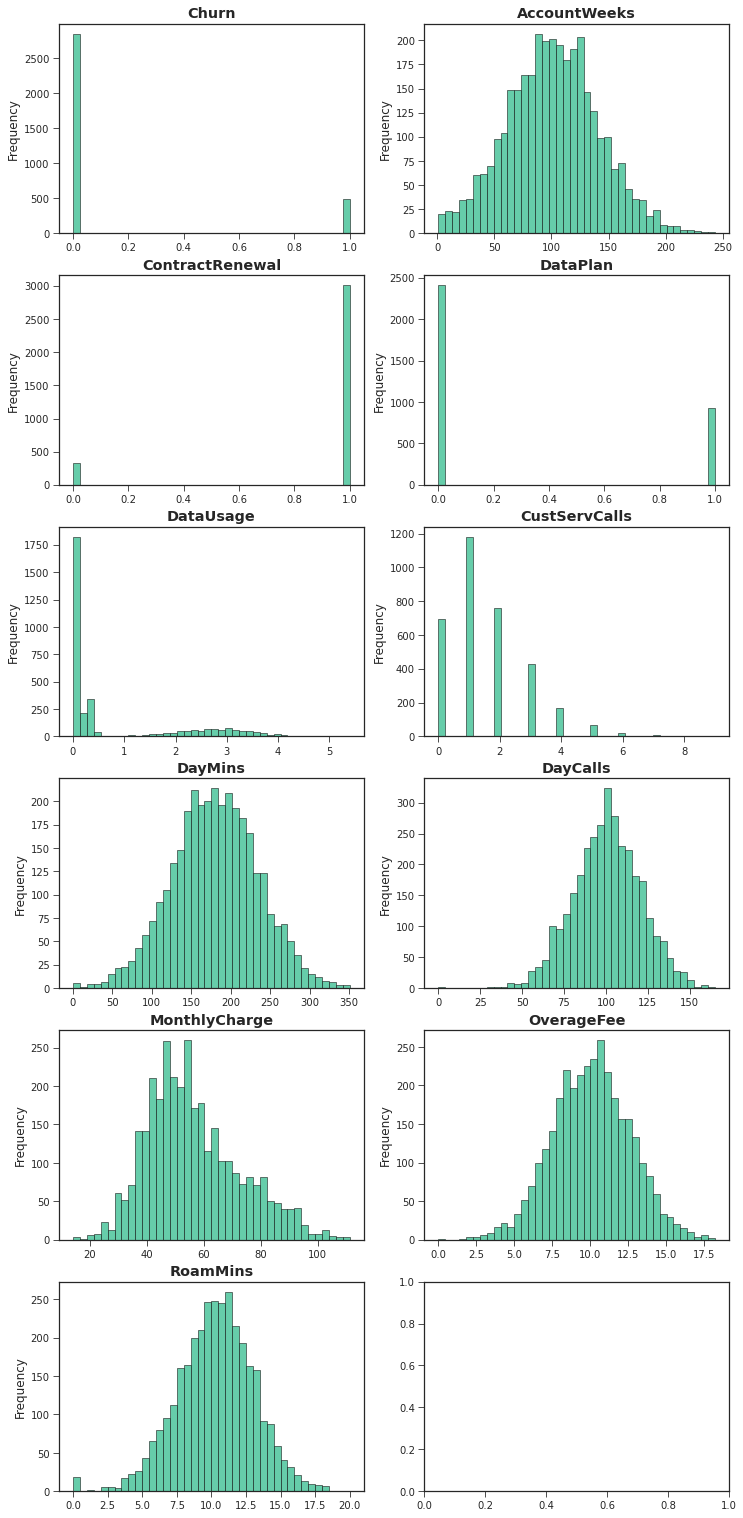

In [1160]:
with plt.style.context(('seaborn-ticks')):
    fig, ax = plt.subplots(6,2, figsize= (12,27))
    i=0
    for i in range(6):
        ax[i][0].hist(df.iloc[:,2*i], edgecolor= 'k', bins= 40, color= 'mediumaquamarine')
        ax[i][0].set_title(f"{df.columns[2*i]}", weight= 'bold')
        ax[i][0].set_ylabel("Frequency")
        if (i<5):
            ax[i][1].hist(df.iloc[:,2*i+1], edgecolor= 'k', bins=40, color= 'mediumaquamarine')
            ax[i][1].set_title(f"{df.columns[2*i+1]}", weight= 'bold')
            ax[i][1].set_ylabel("Frequency")

## Obeservations:
- Looking at the `Churn` histogram we can see there are far less people choosing to opt out of the service than who are not.
- The contract renewal histogram looks similar too, there are far less more people who are renewing their contract than who don't.
- There are less than half the number of people who use `data plan` than who don't use `data plan`.
- The `Customer Calls` distribution looks like Poisson distribution.
- All the other continuous variables looks more or less like Normal Distribution, except fot `Monthly Charge` which is a bit skewed toward left.
- The `Data Usage` column has a weird distribution. There is high frequency of people with less than 1GB data usage each day. But there seems another distribution with a peak around 3GB. My guess would be the 1st set of people (w/ <1GB data usage per day) are people who only use data with the default given data plan with their call plans, and only need data occationally. Whereas the 2nd group of people rely on data plan for their internet use. (<<-- HOW TO TEST THIS HYPOTHESIS!?)

In [1290]:
sns.pairplot(df, hue= 'Churn', palette= 'deep')

## Observations:
- `DayMins` and `MonthlyCharge` looks to have +ve correlation between them, this means the users with higher hours of daytime call usage have higher monthly bills (Makes sense).
- The columns `DataUsage` and `RoamMins` has a weird perfect correlation between them for some data points I don't know why.
- One can notice the customers with more than 4- `Customer Calls` (number of calls into customer service) or more than 250- `DailyMins` (average daytime minutes per month), have a high probablity of discontinuing the service. Whyy??
- `DayMins` vs `MonthlyCharge` graph looks to have two distinct clusters. (I belive the below one is the ones without data plan and the top one is with data plan)
- We will divide the data into 1. Customers w/ data plan vs 2. Customers without data plan, and see how it behaves.

In [1162]:
data_plan_no= df.loc[df['DataPlan']<1]
data_plan_yes= df.loc[df['DataPlan']>=1]
print(data_plan_yes.shape)
print(data_plan_no.shape)

(922, 11)
(2411, 11)


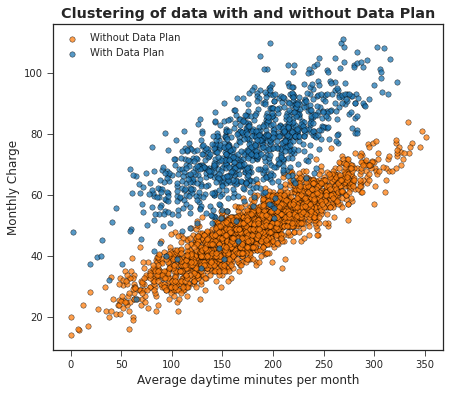

In [1163]:
with plt.style.context(('seaborn-ticks')):
    plt.figure(figsize= (7,6))
    plt.scatter(data_plan_no['DayMins'], data_plan_no['MonthlyCharge'], label= 'Without Data Plan', s= 29, alpha= 0.75, color= 'tab:orange', edgecolor= 'k')
    plt.scatter(data_plan_yes['DayMins'], data_plan_yes['MonthlyCharge'], label= 'With Data Plan', s=29, alpha= 0.75, color= 'tab:blue', edgecolor= 'k')
    plt.xlabel("Average daytime minutes per month")
    plt.ylabel("Monthly Charge")
    plt.title("Clustering of data with and without Data Plan", weight= 'bold')
    plt.legend()

In [1164]:
with plt.style.context(('seaborn-ticks')):
    fig, ax = plt.subplots(1,2, figsize= (14,5.5))
    sns.scatterplot(data=data_plan_yes, x= 'DayMins', y= 'MonthlyCharge', hue= "Churn", ax= ax[0], palette="deep")
    ax[0].set_title("With Data Plan", weight= 'bold')
    ax[0].grid()
    
    sns.scatterplot(data=data_plan_no, x= 'DayMins', y= 'MonthlyCharge', hue= "Churn", ax= ax[1], palette="deep")
    ax[1].set_title("Without Data Plan", weight= 'bold')
    ax[1].grid()

### - It is quite clear from the graphs above the customers are segmented into two parts, 1) With added Data Plan and 2) Without added Data Plan

### - The customers with external Data Plan subscription have higher Monthly Charge. Makes sence since they must be charged extra for the Data Plan.

### - The customers without Data Plan and with Monthly Charge greater than ~60 are highly likely to Churn. As can be seen from the right last graph.

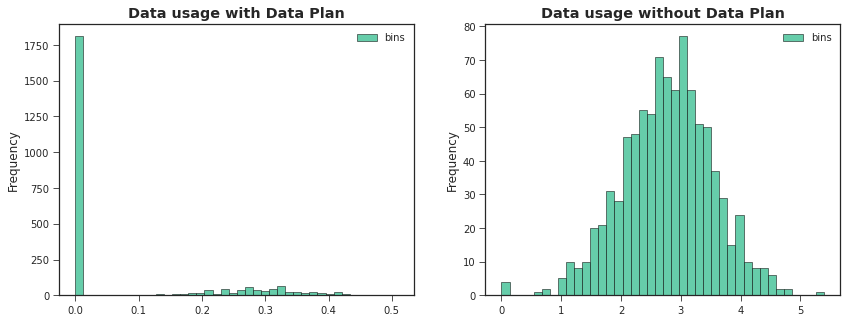

In [1165]:
with plt.style.context(('seaborn-ticks')):
    fig, ax = plt.subplots(1,2, figsize= (14,5))
    ax[0].hist(data_plan_no['DataUsage'], bins= 40, edgecolor= 'k', color= 'mediumaquamarine', label= 'bins')
    ax[0].set_ylabel("Frequency")
    ax[0].set_title("Data usage with Data Plan", weight= 'bold')
    ax[0].legend()
    
    ax[1].hist(data_plan_yes['DataUsage'], bins= 40, edgecolor= 'k', color= 'mediumaquamarine', label= 'bins')
    ax[1].set_ylabel("Frequency")
    ax[1].set_title("Data usage without Data Plan", weight= 'bold')
    ax[1].legend()

### This explains the weird distribution of Data usage, once we segment our data into customers with and without data plan, we can see the distribution makes much more sense.

In [1166]:
with plt.style.context(('seaborn-ticks')):
    plt.figure(figsize= (7,5.5))
    sns.scatterplot(data=df, x= 'AccountWeeks', y= 'CustServCalls', hue= "Churn", palette="deep")
    plt.title("Whole Dataset", weight= 'bold')
    plt.grid()  

with plt.style.context(('seaborn-ticks')):
    fig, ax = plt.subplots(1,2, figsize= (14,5))
    sns.scatterplot(data=data_plan_yes, x= 'AccountWeeks', y= 'CustServCalls', hue= "Churn", ax= ax[0], palette="deep")
    ax[0].set_title("With Data Plan", weight= 'bold')
    ax[0].grid()    
    
    sns.scatterplot(data=data_plan_no, x= 'AccountWeeks', y= 'CustServCalls', hue= "Churn", ax= ax[1], palette="deep")
    ax[1].set_title("Without Data Plan", weight= 'bold')
    ax[1].grid()

### Probability of discontinuing service with number of customer care calls

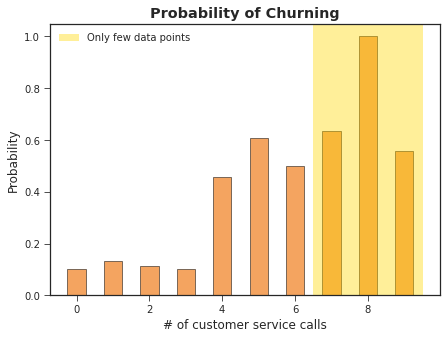

In [1167]:
with plt.style.context(('seaborn-ticks')):
    plt.figure(figsize=(7,5))
    plt.bar(df["CustServCalls"].unique(),df.groupby(by=["CustServCalls"]).mean()['Churn'], color= 'sandybrown', width= 0.5, edgecolor= 'k')
    plt.title("Probability of Churning", weight= 'bold')
    plt.ylabel("Probability")
    plt.xlabel("# of customer service calls")
    plt.axvspan(6.5, 9.5, color='gold', alpha=0.4, lw=0, label= 'Only few data points')
    plt.legend()
    

### It is clear from the bar graph above, the probability of churning increases substantially if number of service center calls is more than 3. If a customer calls the customer service multiple times it probably means they are facing some issues. So multiple calls to the call center by any customer is not a good indication, it means their issue is not being fixed, thus chances of discontinuing service is higher!

In [1168]:
with plt.style.context(('seaborn-ticks')):
    fig, ax = plt.subplots(1,2, figsize= (14,5.5))
    sns.scatterplot(data=data_plan_yes, x= 'DataUsage', y= 'RoamMins', hue= "Churn", ax= ax[0], palette="deep")
    ax[0].set_title("With Data Plan", weight= 'bold')
    ax[0].grid()
    
    sns.scatterplot(data=data_plan_no, x= 'DataUsage', y= 'RoamMins', hue= "Churn", ax= ax[1], palette="deep")
    ax[1].set_title("Without Data Plan", weight= 'bold')
    ax[1].grid()

###  ^^^ Why is this?? idk ^^^

In [1169]:
contract_renew_no= df.loc[df['ContractRenewal']==0]
contract_renew_yes= df.loc[df['ContractRenewal']==1]
print(contract_renew_no.shape)
print(contract_renew_yes.shape)

(323, 11)
(3010, 11)


In [1170]:
with plt.style.context(('seaborn-ticks')):
    fig, ax = plt.subplots(1,2, figsize= (14,5))
    ax[0].hist(contract_renew_yes['MonthlyCharge'], bins= 30, alpha= 0.7, color= 'mediumaquamarine', edgecolor= 'k')
    ax[0].hist(contract_renew_no['MonthlyCharge'], bins= 30, alpha= 0.9, color= 'tab:orange', edgecolor= 'k')
    
    ax[1].hist(contract_renew_yes['DayMins'], bins= 30, alpha= 0.7, color= 'mediumaquamarine', edgecolor= 'k')
    ax[1].hist(contract_renew_no['DayMins'], bins= 30, alpha= 0.9, color= 'tab:orange', edgecolor= 'k')    


In [1171]:
corr= df.corr()
f, ax = plt.subplots(figsize=(12, 9))
cmap= sns.color_palette("light:#5A9", as_cmap=True)
sns.heatmap(corr, square=True, cmap=cmap, vmax=1)
plt.title("Correlation Plot", weight= 'bold', size= 22)

Text(0.5, 1.0, 'Correlation Plot')

# -------------------------------------------------------------------------------------------

# Outlier Detection
We will detect outliers using Z-score method of outlier detection. **If we assume the numerical variables are roughly Normally distributed**, then

$$ \frac{X-\mu}{\sigma} = N(0,1) $$

$ ({X-\mu})/{\sigma}$ behaves as standard normal distribution. And from here we can gather which data points are unlikely to occur, are outliers.

### Looking at the histograms, it doesn't look there are any outliers as such. 

In [1172]:
outlier_columns= ["AccountWeeks", "DayMins", "DayCalls", "OverageFee", "OverageFee", "MonthlyCharge"]

In [1173]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Churn            3333 non-null   int64  
 1   AccountWeeks     3333 non-null   int64  
 2   ContractRenewal  3333 non-null   int64  
 3   DataPlan         3333 non-null   int64  
 4   DataUsage        3333 non-null   float64
 5   CustServCalls    3333 non-null   int64  
 6   DayMins          3333 non-null   float64
 7   DayCalls         3333 non-null   int64  
 8   MonthlyCharge    3333 non-null   float64
 9   OverageFee       3333 non-null   float64
 10  RoamMins         3333 non-null   float64
dtypes: float64(5), int64(6)
memory usage: 286.6 KB


In [1174]:
outiler_df= pd.DataFrame()
for col in outlier_columns:
        outiler_df[col]= (df[col]-df.describe()[col][1])/df.describe()[col][2]

In [1175]:
df.describe()['AccountWeeks'][2]

39.822105928595604

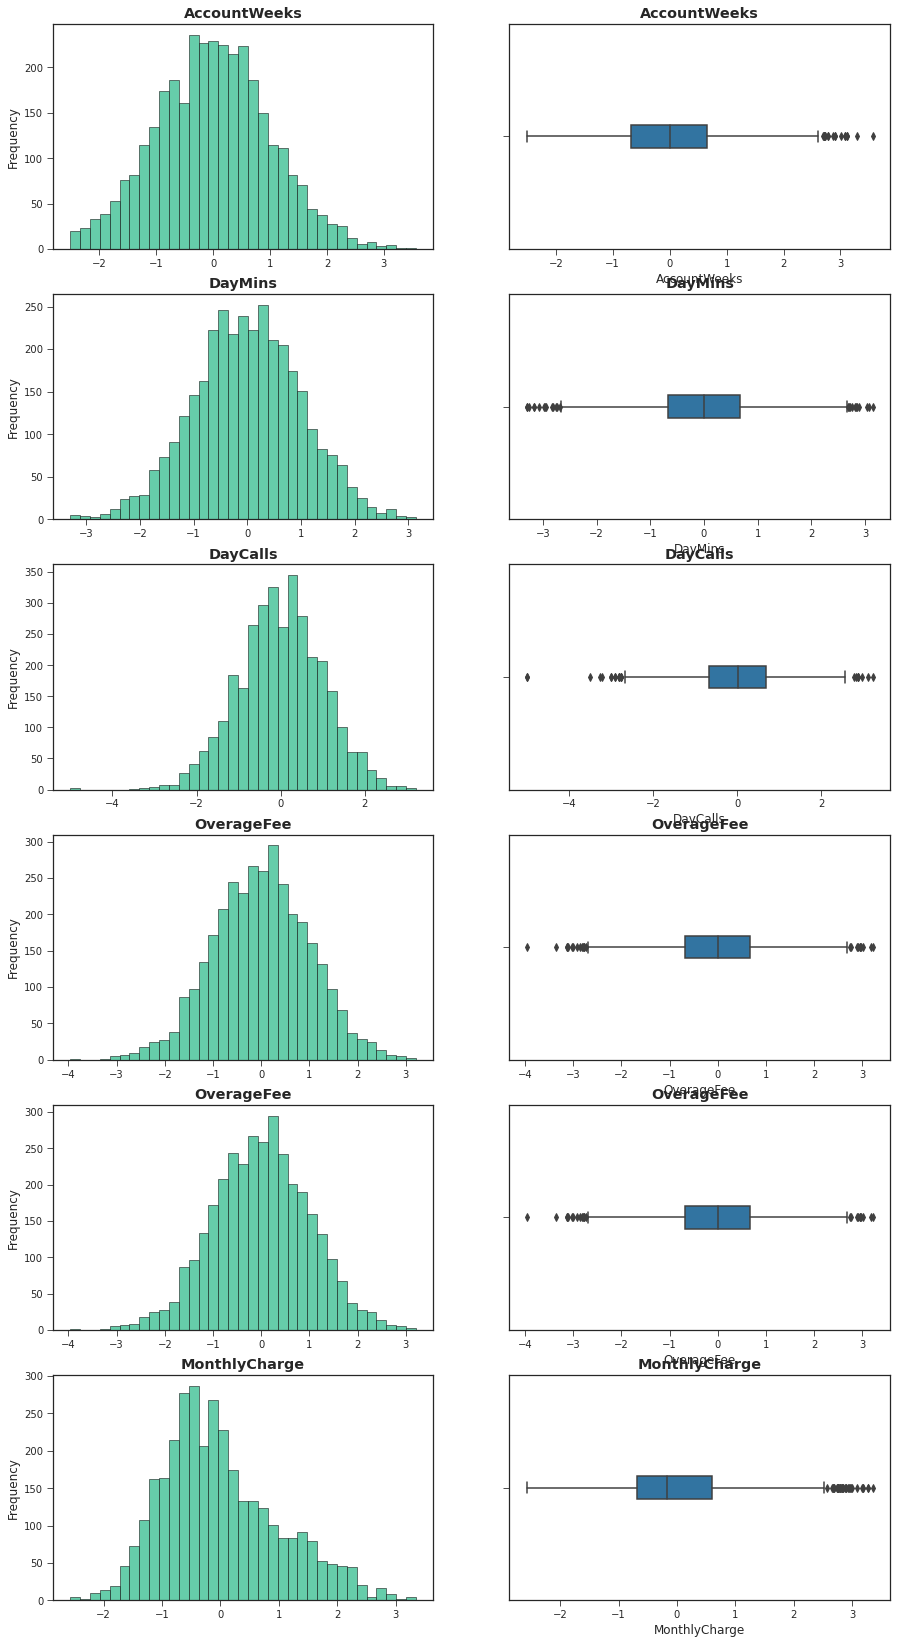

In [1176]:
i=0
with plt.style.context(('seaborn-ticks')):
    fig, ax = plt.subplots(6,2, figsize= (15,29))
    for col in outlier_columns:
        ax[i][0].hist(outiler_df[col], bins=35, edgecolor= 'k', color= 'mediumaquamarine')
        ax[i][0].set_title(col, weight= 'bold')
        ax[i][0].set_ylabel("Frequency")
        
        ax[i][0]= sns.boxplot(x= outiler_df[col], data= outiler_df[col], width= 0.1, ax= ax[i][1], color= 'tab:blue')
        ax[i][0].set_title(col, weight= 'bold')
        i=i+1

### Deleting outlier values

In [1177]:
oau= outiler_df[outiler_df['DayCalls']< -4].index.values

In [1178]:
(df.iloc[oau]-df.describe()['DayCalls'][1])/df.describe()['DayCalls'][2]

Churn  AccountWeeks  ContractRenewal  DataPlan  DataUsage  \
1345 -4.954668     -0.121363        -4.954668 -5.004496  -5.004496   
1397 -5.004496      0.028121        -4.954668 -5.004496  -4.989547   

      CustServCalls   DayMins  DayCalls  MonthlyCharge  OverageFee  RoamMins  
1345      -4.805184 -5.004496 -5.004496      -4.306905   -4.606869 -4.665666  
1397      -4.954668 -5.004496 -5.004496      -4.007938   -4.525650 -4.645735

In [1179]:
df= df.drop(oau)

In [1180]:
opu= outiler_df[outiler_df['OverageFee']< -3.5].index.values
(df.iloc[oau]-df.describe()['OverageFee'][1])/df.describe()['OverageFee'][2]

Churn  AccountWeeks  ContractRenewal  DataPlan  DataUsage  \
1346 -3.569204     37.831192        -3.963494 -3.963494  -3.963494   
1399 -3.963494     37.042613        -3.569204 -3.963494  -3.833378   

      CustServCalls    DayMins   DayCalls  MonthlyCharge  OverageFee  RoamMins  
1346      -3.569204  48.753011  13.779533      11.413797   -0.261115  0.255404  
1399      -2.386336  62.119425  41.774087      16.263557    0.357919  0.649693

In [1181]:
df= df.drop(opu)

In [1182]:
df.shape

(3330, 11)

In [1183]:
plt.style.use('ggplot')
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


# -------------------------------------------------------------------------------------------

# MODELLING!!

In [1184]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

### In modeling we will try different models for binary classification, where we will try to vary the parameters to see which fits the data best. Also, from the data we have observed that it can be segmented into two parts- One with `DataPlan` and One withpout `DataPlan`. The one without Data Plan can give a good predictor of Churning (probability of Churning incerases signigicantly with Monthly Bill > 60 - for ones without DataPlan).

### Thus we will also divide the Data into these two parts with and without DataPlan, and fit into models to see which performs better.!

## We first Standardize the data and divide into test-train

In [1185]:
scaler= StandardScaler()
df_standard= scaler.fit_transform(df)
df_standard
df_standard= pd.DataFrame(data= df_standard, columns= df.columns)

In [1186]:
df_standard.head()  #Standardized df

Churn  AccountWeeks  ContractRenewal  DataPlan  DataUsage  CustServCalls  \
0 -0.41139      0.676132         0.327744  1.616080   1.479250      -0.427684   
1 -0.41139      0.148944         0.327744  1.616080   2.264881      -0.427684   
2 -0.41139      0.902070         0.327744 -0.618781  -0.641955      -1.188062   
3 -0.41139     -0.428453        -3.051163 -0.618781  -0.641955       0.332694   
4 -0.41139     -0.654390        -3.051163 -0.618781  -0.641955       1.093072   

    DayMins  DayCalls  MonthlyCharge  OverageFee  RoamMins  
0  1.569453  0.477734       1.991930   -0.073220 -0.085537  
1 -0.336525  1.130505       1.565068   -0.108790  1.239956  
2  1.169843  0.678587      -0.264341   -1.579020  0.702594  
3  2.201096 -1.480580       0.040560   -2.748880 -1.303557  
4 -0.242607  0.628374      -0.935125   -1.041516 -0.049713

In [1187]:
df_standard_X= df_standard.drop(columns= 'Churn')

In [1188]:
df_standard_X.head()

AccountWeeks  ContractRenewal  DataPlan  DataUsage  CustServCalls  \
0      0.676132         0.327744  1.616080   1.479250      -0.427684   
1      0.148944         0.327744  1.616080   2.264881      -0.427684   
2      0.902070         0.327744 -0.618781  -0.641955      -1.188062   
3     -0.428453        -3.051163 -0.618781  -0.641955       0.332694   
4     -0.654390        -3.051163 -0.618781  -0.641955       1.093072   

    DayMins  DayCalls  MonthlyCharge  OverageFee  RoamMins  
0  1.569453  0.477734       1.991930   -0.073220 -0.085537  
1 -0.336525  1.130505       1.565068   -0.108790  1.239956  
2  1.169843  0.678587      -0.264341   -1.579020  0.702594  
3  2.201096 -1.480580       0.040560   -2.748880 -1.303557  
4 -0.242607  0.628374      -0.935125   -1.041516 -0.049713

In [1189]:
df_standard_Y= df_standard["Churn"]
df_standard_Y.head()

0   -0.41139
1   -0.41139
2   -0.41139
3   -0.41139
4   -0.41139
Name: Churn, dtype: float64

In [1190]:
X_train, X_test, y_train, y_test = train_test_split(df_standard_X, df['Churn'], test_size=0.33, random_state=42)
print('X_train Size:\t', X_train.shape)
print('y_train Size:\t', y_train.shape)
print('X_test Size:\t', X_test.shape)
print('y_test Size:\t', y_test.shape)

X_train Size:	 (2231, 10)
y_train Size:	 (2231,)
X_test Size:	 (1099, 10)
y_test Size:	 (1099,)


In [1191]:
X_train.head()

AccountWeeks  ContractRenewal  DataPlan  DataUsage  CustServCalls  \
2359     -0.880328         0.327744 -0.618781  -0.382697       1.093072   
1251     -0.353140         0.327744 -0.618781  -0.641955       1.093072   
1905     -0.328036         0.327744  1.616080   1.439968       0.332694   
626      -0.152306        -3.051163  1.616080   0.230096      -1.188062   
347       1.529675         0.327744 -0.618781  -0.641955      -0.427684   

       DayMins  DayCalls  MonthlyCharge  OverageFee  RoamMins  
2359 -1.168894 -0.124824      -1.526634   -2.084905  0.093584  
1251 -0.198410  0.226668      -0.752184   -0.614675 -0.121361  
1905  0.197518  0.176455       1.412617    0.717227 -0.157185  
626   0.742609  0.427521       0.534501   -0.310353 -2.199161  
347   0.749975  0.829226      -0.325322   -0.907140  0.093584

In [1192]:
y_test

438     0
1824    0
997     0
1791    0
3139    0
       ..
2679    0
2715    0
2117    0
1132    0
3031    0
Name: Churn, Length: 1099, dtype: int64

# 1. Logistic Regression

For Logistic Regression we are using the Regularized $L_2$ Loss function (Which is provided by default for sklearn logistic regression class). The goa is to minimize the Loss function.

$$ Loss_2 = \sum_i^n\big(y_i - \sum_j^p x_{ij}\beta_j\big)^2 + \lambda \sum_j^p \beta_j^2 $$

We will try to vary $\lambda$ and see how different models perform (It is set to 1 by default).

In [1193]:
logreg = LogisticRegression(random_state=16)

# fit the model with data
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [1194]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93       966
           1       0.46      0.22      0.30       133

    accuracy                           0.87      1099
   macro avg       0.68      0.59      0.61      1099
weighted avg       0.85      0.87      0.85      1099



### We can see Precision and Recall for both `Churn`= 1 is fairly high but for `Churn`= 0 it is low. I think it is because the # of 0 instances is high and the # of 1 instances is low.

### We will try resampling methods to balance the classes and then see how the performance changes.

link- https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/

In [1195]:
print(df['Churn'].value_counts())
print("\n%age=", 482/(482+2848)*100)

0    2848
1     482
Name: Churn, dtype: int64

%age= 14.474474474474475


In [1196]:
#Randomly draws sample w/ Churn=1 from the dataframe
df2 = df.loc[df['Churn']==0].sample(n=518).copy()
df1= df.loc[df['Churn']==1].copy()

#Concatenating both dataframes
df_undersampld= pd.concat([df1,df2], ignore_index= True)
# shuffle the DataFrame rows
df_undersampld = df_undersampld.sample(frac = 1)

In [1197]:
y_undersampled= df_undersampld['Churn']
y_undersampled.head()

312    1
761    0
242    1
66     1
642    0
Name: Churn, dtype: int64

In [1198]:
df_undersampld.head()

Churn  AccountWeeks  ContractRenewal  DataPlan  DataUsage  CustServCalls  \
312      1            82                1         0       0.31              6   
761      0           115                1         0       0.00              1   
242      1           107                1         0       0.00              1   
66       1            92                0         0       0.21              2   
642      0           199                1         1       2.16              0   

     DayMins  DayCalls  MonthlyCharge  OverageFee  RoamMins  
312    167.1        77           43.1        6.59       9.4  
761    127.7        67           38.0        9.15      10.6  
242    222.3       101           63.0       14.30      12.1  
66     130.7       113           47.1       13.03       9.4  
642    230.6       121           79.6       10.97       8.0

### Standardizing Undersampled data

In [1199]:
scaler= StandardScaler()
X_undersampld_std= scaler.fit_transform(df_undersampld)
X_undersampld_std
X_undersampld_std= pd.DataFrame(data= X_undersampld_std, columns= df_undersampld.columns)
X_undersampld_std= X_undersampld_std.drop(columns= 'Churn')
X_undersampld_std.head()

AccountWeeks  ContractRenewal  DataPlan  DataUsage  CustServCalls  \
0     -0.448064          0.44614 -0.535725  -0.304649       2.635096   
1      0.391388          0.44614 -0.535725  -0.563152      -0.504914   
2      0.187885          0.44614 -0.535725  -0.563152      -0.504914   
3     -0.193684         -2.24145 -0.535725  -0.388037       0.123088   
4      2.528173          0.44614  1.866629   1.238026      -1.132916   

    DayMins  DayCalls  MonthlyCharge  OverageFee  RoamMins  
0 -0.344698 -1.173369      -0.858946   -1.437804 -0.325372  
1 -0.977147 -1.659196      -1.177088   -0.456111  0.086883  
2  0.541374 -0.007385       0.382432    1.518778  0.602201  
3 -0.928991  0.575608      -0.609423    1.031767 -0.325372  
4  0.674605  0.964269       1.417953    0.241811 -0.806336

### Running Logistic Regression

In [1200]:
X_train, X_test, y_train, y_test = train_test_split(X_undersampld_std, y_undersampled, test_size=0.33, random_state=42)
print('X_train Size:\t', X_train.shape)
print('y_train Size:\t', y_train.shape)
print('X_test Size:\t', X_test.shape)
print('y_test Size:\t', y_test.shape)

X_train Size:	 (670, 10)
y_train Size:	 (670,)
X_test Size:	 (330, 10)
y_test Size:	 (330,)


In [1201]:
logreg = LogisticRegression(random_state=16)
logreg.fit(X_train, y_train) 
y_pred = logreg.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.79      0.79       179
           1       0.75      0.74      0.75       151

    accuracy                           0.77       330
   macro avg       0.77      0.77      0.77       330
weighted avg       0.77      0.77      0.77       330



In [1202]:
logreg = LogisticRegression(random_state=16, C= 0.0001)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.98      0.74       179
           1       0.91      0.19      0.32       151

    accuracy                           0.62       330
   macro avg       0.75      0.59      0.53       330
weighted avg       0.74      0.62      0.55       330



In [1203]:
logreg = LogisticRegression(random_state=16, C= 0.001)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.82      0.78       179
           1       0.75      0.67      0.71       151

    accuracy                           0.75       330
   macro avg       0.75      0.74      0.74       330
weighted avg       0.75      0.75      0.75       330



In [1204]:
logreg = LogisticRegression(random_state=16, C= 0.005)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.79      0.78       179
           1       0.74      0.70      0.72       151

    accuracy                           0.75       330
   macro avg       0.75      0.75      0.75       330
weighted avg       0.75      0.75      0.75       330



In [1205]:
logreg = LogisticRegression(random_state=16, C= 0.01)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.79      0.78       179
           1       0.74      0.72      0.73       151

    accuracy                           0.76       330
   macro avg       0.76      0.75      0.76       330
weighted avg       0.76      0.76      0.76       330



## From trying around different variations of $\lambda$ (Regularization Constant) values, we find $\lambda= 1$ works well with the data. So we will go with this.

## Now we will try to build a model such that we make use of the fact Monthly Bill can be good predictor of Churning for users with no Data Plan

In [1206]:
colm01= ['AccountWeeks', 'ContractRenewal', 'DataUsage',
       'CustServCalls', 'DayMins', 'DayCalls', 'MonthlyCharge', 'OverageFee',
       'RoamMins']
len(colm01)

9

In [1207]:
standard_df=copy.deepcopy(df_undersampld)

In [1208]:
#Standardizing df
standard= StandardScaler()
standard_df[colm01]= standard.fit_transform(df_undersampld[colm01])
standard_df.head()

Churn  AccountWeeks  ContractRenewal  DataPlan  DataUsage  CustServCalls  \
312      1     -0.448064          0.44614         0  -0.304649       2.635096   
761      0      0.391388          0.44614         0  -0.563152      -0.504914   
242      1      0.187885          0.44614         0  -0.563152      -0.504914   
66       1     -0.193684         -2.24145         0  -0.388037       0.123088   
642      0      2.528173          0.44614         1   1.238026      -1.132916   

      DayMins  DayCalls  MonthlyCharge  OverageFee  RoamMins  
312 -0.344698 -1.173369      -0.858946   -1.437804 -0.325372  
761 -0.977147 -1.659196      -1.177088   -0.456111  0.086883  
242  0.541374 -0.007385       0.382432    1.518778  0.602201  
66  -0.928991  0.575608      -0.609423    1.031767 -0.325372  
642  0.674605  0.964269       1.417953    0.241811 -0.806336

In [1209]:
#test-train split
train, test = train_test_split(df_undersampld, test_size=0.33, random_state=42)
print(train.shape)
print(test.shape)

(670, 11)
(330, 11)


my name is legendary Mohanta! Thanks =)

In [1210]:
train.head(4)

Churn  AccountWeeks  ContractRenewal  DataPlan  DataUsage  CustServCalls  \
370      1            88                1         0       0.39              4   
309      1           113                1         0       0.00              3   
571      0           108                1         0       0.00              0   
683      0           107                1         0       0.00              1   

     DayMins  DayCalls  MonthlyCharge  OverageFee  RoamMins  
370    301.5       136           77.9       12.89      13.4  
309    245.3       108           64.0       13.00      10.7  
571    199.3       104           53.0       11.21      15.2  
683    157.1        79           41.0        8.13      12.1

In [1211]:
train.loc[train['DataPlan']==0]

Churn  AccountWeeks  ContractRenewal  DataPlan  DataUsage  CustServCalls  \
370      1            88                1         0       0.39              4   
309      1           113                1         0       0.00              3   
571      0           108                1         0       0.00              0   
683      0           107                1         0       0.00              1   
312      1            82                1         0       0.31              6   
..     ...           ...              ...       ...        ...            ...   
268      1            49                0         0       0.26              2   
726      0           123                1         0       0.15              3   
176      1           108                1         0       0.00              4   
350      1           119                1         0       0.00              0   
946      0           106                1         0       0.00              1   

     DayMins  DayCalls  MonthlyCharge  OverageFee  RoamMins  
370    301.5       136           77.9       12.89      13.4  
309    245.3       108           64.0       13.00      10.7  
571    199.3       104           53.0       11.21      15.2  
683    157.1        79           41.0        8.13      12.1  
312    167.1        77           43.1        6.59       9.4  
..       ...       ...            ...         ...       ...  
268    237.8        92           61.6       10.45      15.6  
726    211.0        92           56.5       10.85       9.8  
176    112.0       105           36.0        9.69       4.1  
350    294.2       100           70.0       11.63       9.0  
946    220.7       120           61.0       13.51       8.7  

[520 rows x 11 columns]

In [1212]:
#All the data plan sums into 0, Checkes out 
train.loc[train['DataPlan']==0]['DataPlan'].sum()

0

In [1213]:
X_columns= ['AccountWeeks', 'ContractRenewal', 'DataPlan', 'DataUsage',
       'CustServCalls', 'DayMins', 'DayCalls', 'MonthlyCharge', 'OverageFee',
       'RoamMins']
Y_columns= ['Churn']

In [1214]:
X_columns, Y_columns

(['AccountWeeks',
  'ContractRenewal',
  'DataPlan',
  'DataUsage',
  'CustServCalls',
  'DayMins',
  'DayCalls',
  'MonthlyCharge',
  'OverageFee',
  'RoamMins'],
 ['Churn'])

In [1215]:
#This is X_train for DataPlan=0
train.loc[train['DataPlan']==0][X_columns]

AccountWeeks  ContractRenewal  DataPlan  DataUsage  CustServCalls  \
370            88                1         0       0.39              4   
309           113                1         0       0.00              3   
571           108                1         0       0.00              0   
683           107                1         0       0.00              1   
312            82                1         0       0.31              6   
..            ...              ...       ...        ...            ...   
268            49                0         0       0.26              2   
726           123                1         0       0.15              3   
176           108                1         0       0.00              4   
350           119                1         0       0.00              0   
946           106                1         0       0.00              1   

     DayMins  DayCalls  MonthlyCharge  OverageFee  RoamMins  
370    301.5       136           77.9       12.89      13.4  
309    245.3       108           64.0       13.00      10.7  
571    199.3       104           53.0       11.21      15.2  
683    157.1        79           41.0        8.13      12.1  
312    167.1        77           43.1        6.59       9.4  
..       ...       ...            ...         ...       ...  
268    237.8        92           61.6       10.45      15.6  
726    211.0        92           56.5       10.85       9.8  
176    112.0       105           36.0        9.69       4.1  
350    294.2       100           70.0       11.63       9.0  
946    220.7       120           61.0       13.51       8.7  

[520 rows x 10 columns]

In [1216]:
#This is Y_train for DataPlan=0
train.loc[train['DataPlan']==0][Y_columns]

Churn
370      1
309      1
571      0
683      0
312      1
..     ...
268      1
726      0
176      1
350      1
946      0

[520 rows x 1 columns]

In [1217]:
logreg = LogisticRegression(random_state=16, C= 0.01, max_iter= 300)
logreg.fit(train.loc[train['DataPlan']==0][X_columns], train.loc[train['DataPlan']==0][Y_columns])
#y_pred = logreg.predict(X_test)
#print(classification_report(y_test, y_pred))
DataPlan0_Coeffs= logreg.coef_
DataPlan0_CoeffNames= logreg.feature_names_in_ 
DataPlan0_intercept= logreg.intercept_

/Users/ritobrotomohanta/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


**These are the coefficients of used for the model, and the coefficients ($\beta$'s) values**

$$ p(x)= \frac{1}{1+e^{\beta_0+\beta_1 x_1+.. \beta_p x_p}}$$

In [1218]:
DataPlan0_CoeffNames

array(['AccountWeeks', 'ContractRenewal', 'DataPlan', 'DataUsage',
       'CustServCalls', 'DayMins', 'DayCalls', 'MonthlyCharge',
       'OverageFee', 'RoamMins'], dtype=object)

In [1219]:
DataPlan0_Coeffs[0]

array([ 0.00314983, -0.23013103,  0.        , -0.01415121,  0.3307278 ,
        0.01568134,  0.00512949, -0.00629057,  0.07960656,  0.06106872])

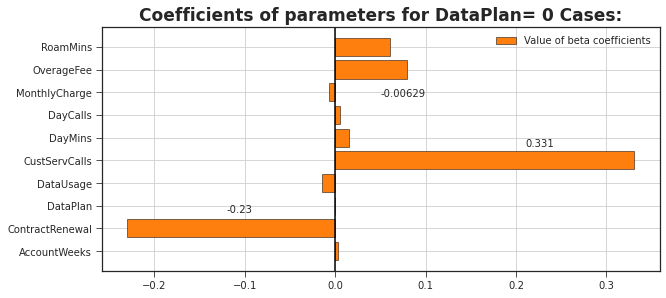

In [1220]:
with plt.style.context(('seaborn-ticks')):
    plt.figure(figsize= (10,4.5))
    plt.barh(DataPlan0_CoeffNames, DataPlan0_Coeffs[0], height= 0.8, color= 'tab:orange', label= "Value of beta coefficients", edgecolor='k')
    plt.axvline(x = 0, color = 'k')
    plt.text(x=0.05, y=6.8, s=  '{:.3}'.format(DataPlan0_Coeffs[0][7]))
    plt.text(x=0.21, y=4.6, s= '{:.3}'.format(DataPlan0_Coeffs[0][4]))
    plt.text(x=-0.12, y=1.7, s= '{:.3}'.format(DataPlan0_Coeffs[0][1]))
    plt.grid()
    plt.title("Coefficients of parameters for DataPlan= 0 Cases:", weight='bold', size= 17)
    plt.legend()

## NOTICE!

### from the above graph we can see three of the strongest predictor of Churning is `CustSerCalls` ($\beta_7= 0.24$) followed by `ContractRenewal`  ($\beta_1= -0.12$) and followed by `MonthlyCharge`  ($\beta_4= 0.046$).


### Contract Renewal is negetively related to churning, as its $\beta$ value is -ve. Which means if a customer has recently renewed their contract, the probability of their churning is lower (makes sense)

### Third strongest predictor is Monthly Charge - $\beta_4= 0.046$ . In the Data Analysis part we had seen that probabilty of churing increases strongly after Monthly Charge > 60. Hopefully this model captures this

### Also notice the coefficient of Data Plan is exactly 0. This is because all the Data points in this subset is has `DataPlan` =0. So the coefficient is also 0 (Since there is no variation in the r.v.)

In [1221]:
#This is X_train for DataPlan=1
train.loc[train['DataPlan']==1][X_columns]

AccountWeeks  ContractRenewal  DataPlan  DataUsage  CustServCalls  \
392           134                1         1       1.65              2   
650            55                1         1       3.38              2   
492           116                1         1       1.62              2   
842            21                1         1       2.57              6   
148           119                0         1       2.35              5   
..            ...              ...       ...        ...            ...   
429           147                1         1       2.73              2   
100           149                0         1       2.38              5   
600           139                1         1       2.24              0   
185            67                0         1       4.56              0   
536            77                1         1       1.92              2   

     DayMins  DayCalls  MonthlyCharge  OverageFee  RoamMins  
392    247.2       105           78.5       11.28       6.1  
650    189.3        95           76.8        5.93      12.5  
492    183.6       138           65.2       10.19       6.0  
842    135.9        90           72.7       13.55       9.5  
148    160.0        95           69.5       10.48       8.7  
..       ...       ...            ...         ...       ...  
429    197.3       134           73.3        7.06      10.1  
100    126.9        97           59.8        8.35       8.8  
600    138.3        96           53.4        4.03       8.3  
185    181.1        59           95.6       10.80      16.9  
536    209.7        73           71.2        9.18       7.1  

[150 rows x 10 columns]

In [1222]:
test.loc[test['DataPlan']==0][X_columns]

AccountWeeks  ContractRenewal  DataPlan  DataUsage  CustServCalls  \
602            84                1         0       0.16              2   
852            86                1         0       0.00              4   
485           138                1         0       0.00              3   
814            93                1         0       0.00              1   
57            224                0         0       0.26              1   
..            ...              ...       ...        ...            ...   
89             76                1         0       0.00              0   
760            69                1         0       0.00              3   
228            77                1         0       0.00              0   
254            68                1         0       0.00              2   
978           141                1         0       0.00              1   

     DayMins  DayCalls  MonthlyCharge  OverageFee  RoamMins  
602    130.2       105           47.6       13.90      14.0  
852    226.3        88           58.0       11.15      13.0  
485    241.8        93           56.0        8.53      11.8  
814    179.3        93           47.0        9.44      12.1  
57     171.5        99           45.6        8.00       5.0  
..       ...       ...            ...         ...       ...  
89     299.5       125           71.0       11.34      13.7  
760    228.2        70           62.0       13.19      10.7  
228    245.2        87           64.0       12.71       7.5  
254    249.9       127           65.0       12.73       8.9  
978    126.9        98           37.0        9.00       8.0  

[257 rows x 10 columns]

In [1223]:
#This is Y_train for DataPlan=1
train.loc[train['DataPlan']==1][Y_columns]

Churn
392      1
650      0
492      0
842      0
148      1
..     ...
429      1
100      1
600      0
185      1
536      0

[150 rows x 1 columns]

In [1224]:
logreg = LogisticRegression(random_state=16, C= 0.01, max_iter= 300)
logreg.fit(train.loc[train['DataPlan']==1][X_columns], train.loc[train['DataPlan']==1][Y_columns])
#y_pred = logreg.predict(X_test)
#print(classification_report(y_test, y_pred))
DataPlan1_Coeffs= logreg.coef_
DataPlan1_CoeffNames= logreg.feature_names_in_ 
DataPlan1_intercept= logreg.intercept_

/Users/ritobrotomohanta/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [1225]:
DataPlan1_CoeffNames

array(['AccountWeeks', 'ContractRenewal', 'DataPlan', 'DataUsage',
       'CustServCalls', 'DayMins', 'DayCalls', 'MonthlyCharge',
       'OverageFee', 'RoamMins'], dtype=object)

In [1226]:
DataPlan1_Coeffs

array([[ 7.06163314e-03, -1.12203269e-01, -7.94448597e-06,
         7.73510749e-03,  2.37296463e-01, -3.20565909e-03,
         5.54794672e-03,  3.69441287e-02, -2.74859787e-02,
         2.86607195e-02]])

In [1227]:
with plt.style.context(('seaborn-ticks')):
    plt.figure(figsize= (10,4.5))
    plt.barh(DataPlan1_CoeffNames, DataPlan1_Coeffs[0], height= 0.8, color= 'tab:orange', label= "Value of beta coefficients", edgecolor='k')
    plt.axvline(x = 0, color = 'k')
    plt.text(x=0.18, y=4.6, s= '{:.3}'.format(DataPlan1_Coeffs[0][4]))
    plt.text(x=-0.11, y=1.7, s= '{:.3}'.format(DataPlan1_Coeffs[0][1]))
    plt.text(x=-0.097, y=7.6, s= '{:.2}'.format(DataPlan1_Coeffs[0][8]))
    plt.text(x=0.05, y=8.6, s= '{:.2}'.format(DataPlan1_Coeffs[0][9]))
    plt.grid()
    plt.title("Coefficients of parameters for DataPlan= 1 Cases:", weight='bold', size= 17)
    plt.legend()

### - For `DataPlan`= 1, there are 4 significant predictors of `Churning` 
- CustServCalls
- ContractRenewal
- OverageFee
- RoamMins

### - Again we can check the model is properly run as coefficient of DataPlan is exactly= 0 as the coefficient of `DataPlan`= 0.

### - In this case (`DataPlan`=1) Monthly Charges is not a good predictor of Churning, coeff $\beta_4$ is small. This was also observed during the Data Analysis part. This observation affirms our previous conclusion.


# Building a hybdrid model using these two models

In [1228]:
X_test= test.drop(columns= 'Churn')
X_test.head()

AccountWeeks  ContractRenewal  DataPlan  DataUsage  CustServCalls  \
602            84                1         0       0.16              2   
852            86                1         0       0.00              4   
485           138                1         0       0.00              3   
814            93                1         0       0.00              1   
57            224                0         0       0.26              1   

     DayMins  DayCalls  MonthlyCharge  OverageFee  RoamMins  
602    130.2       105           47.6       13.90      14.0  
852    226.3        88           58.0       11.15      13.0  
485    241.8        93           56.0        8.53      11.8  
814    179.3        93           47.0        9.44      12.1  
57     171.5        99           45.6        8.00       5.0

In [1229]:
def model_pred(beta01, beta00, X_test):
    #Inputs X_test, and Beta parameters and outputs Y-Predicted and Y-Probability
    
    Y_predic= []
    Y_prob= []
    X_test_arr= np.array(X_test)
    print(f"X_test len: {len(X_test)}\n")
    for i in range(len(X_test)):
        if (X_test['DataPlan'].iloc[i]==0):
            Y_prob.append(float(1/(1+np.exp(-DataPlan0_intercept-np.dot(X_test_arr[i],DataPlan0_Coeffs[0])))))
            if (Y_prob[i]>0.5):
                Y_predic.append(1)
            else:
                Y_predic.append(0)
            
            
        if (X_test['DataPlan'].iloc[i]==1):
            Y_prob.append(float(1/(1+np.exp(-DataPlan1_intercept-np.dot(X_test_arr[i],DataPlan1_Coeffs[0])))))
            if (Y_prob[i]>0.5):
                Y_predic.append(1)
            else:
                Y_predic.append(0)
        
    return Y_prob, Y_predic

In [1230]:
y_prob, y_predic= model_pred(DataPlan1_Coeffs[0], DataPlan0_Coeffs[0], X_test)
print(classification_report(test['Churn'], y_predic))

X_test len: 330

              precision    recall  f1-score   support

           0       0.71      0.75      0.73       179
           1       0.68      0.64      0.66       151

    accuracy                           0.70       330
   macro avg       0.70      0.70      0.70       330
weighted avg       0.70      0.70      0.70       330



### All effort gone in vain.. This Model works even worse than just simple Logistic Regression :( (pain)

### For Logistic Regression, simple Logistic regression with regularization constant $\lambda=1$ works the best!

## Here is the Confusion Matrix for the best model we found for Logistic regression

/Users/ritobrotomohanta/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


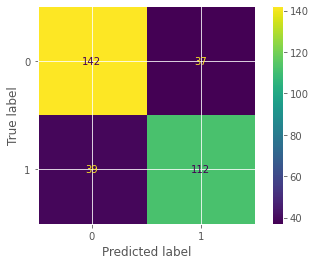


               precision    recall  f1-score   support

           0       0.78      0.79      0.79       179
           1       0.75      0.74      0.75       151

    accuracy                           0.77       330
   macro avg       0.77      0.77      0.77       330
weighted avg       0.77      0.77      0.77       330



In [1231]:
X_train, X_test, y_train, y_test = train_test_split(X_undersampld_std, y_undersampled, test_size=0.33, random_state=42)

logreg = LogisticRegression(random_state=16)
logreg.fit(X_train, y_train) 
y_pred = logreg.predict(X_test)

confusion_matrix(y_test, y_pred)
plot_confusion_matrix(logreg, X_test, y_test)  
plt.show()
print('\n',classification_report(y_test, y_pred))

# -------------------------------------------------------------------------------------------

# 2. K-Nearest Neighbors

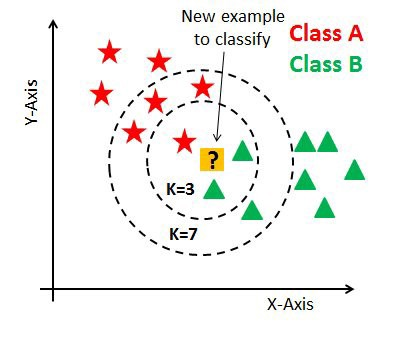
In k-NN classification problems, a class label is assigned on the basis of a majority vote—i.e. the label that is most frequently represented around a given data point is used. 

We can use different metrics to calculate distances between points. 

In [1232]:
#test-train split
X_train, X_test, y_train, y_test = train_test_split(X_undersampld_std, y_undersampled, test_size=0.33, random_state=42)
print('X_train Size:\t', X_train.shape)
print('y_train Size:\t', y_train.shape)
print('X_test Size:\t', X_test.shape)
print('y_test Size:\t', y_test.shape)

X_train Size:	 (670, 10)
y_train Size:	 (670,)
X_test Size:	 (330, 10)
y_test Size:	 (330,)


In [1233]:
neighbors= 2
neigh= KNeighborsClassifier(n_neighbors= neighbors)
neigh.fit(X_train, y_train)
y_pred= neigh.predict(X_test) 
print(f"Neighbors: {neighbors}\n\n")
print(classification_report(y_test, y_pred))

Neighbors: 2


              precision    recall  f1-score   support

           0       0.74      0.91      0.81       179
           1       0.85      0.62      0.72       151

    accuracy                           0.78       330
   macro avg       0.79      0.76      0.77       330
weighted avg       0.79      0.78      0.77       330



In [1234]:
neighbors= 3
neigh= KNeighborsClassifier(n_neighbors= neighbors)
neigh.fit(X_train, y_train)
y_pred= neigh.predict(X_test) 
print(f"Neighbors: {neighbors}\n\n")
print(classification_report(y_test, y_pred))

Neighbors: 3


              precision    recall  f1-score   support

           0       0.83      0.83      0.83       179
           1       0.80      0.80      0.80       151

    accuracy                           0.82       330
   macro avg       0.82      0.82      0.82       330
weighted avg       0.82      0.82      0.82       330



In [1235]:
neighbors= 4
neigh= KNeighborsClassifier(n_neighbors= neighbors)
neigh.fit(X_train, y_train)
y_pred= neigh.predict(X_test) 
print(f"Neighbors: {neighbors}\n\n")
print(classification_report(y_test, y_pred))

Neighbors: 4


              precision    recall  f1-score   support

           0       0.81      0.91      0.86       179
           1       0.88      0.75      0.81       151

    accuracy                           0.84       330
   macro avg       0.84      0.83      0.83       330
weighted avg       0.84      0.84      0.83       330



In [1236]:
neighbors= 5
neigh= KNeighborsClassifier(n_neighbors= neighbors)
neigh.fit(X_train, y_train)
y_pred= neigh.predict(X_test) 
print(f"Neighbors: {neighbors}\n\n")
print(classification_report(y_test, y_pred))

Neighbors: 5


              precision    recall  f1-score   support

           0       0.85      0.84      0.85       179
           1       0.82      0.82      0.82       151

    accuracy                           0.83       330
   macro avg       0.83      0.83      0.83       330
weighted avg       0.83      0.83      0.83       330



In [1237]:
neighbors= 6
neigh= KNeighborsClassifier(n_neighbors= neighbors)
neigh.fit(X_train, y_train)
y_pred= neigh.predict(X_test) 
print(f"Neighbors: {neighbors}\n\n")
print(classification_report(y_test, y_pred))

Neighbors: 6


              precision    recall  f1-score   support

           0       0.82      0.88      0.85       179
           1       0.84      0.77      0.80       151

    accuracy                           0.83       330
   macro avg       0.83      0.82      0.82       330
weighted avg       0.83      0.83      0.83       330



In [1238]:
neighbors= 7
neigh= KNeighborsClassifier(n_neighbors= neighbors)
neigh.fit(X_train, y_train)
y_pred= neigh.predict(X_test) 
print(f"Neighbors: {neighbors}\n\n")
print(classification_report(y_test, y_pred))

Neighbors: 7


              precision    recall  f1-score   support

           0       0.85      0.85      0.85       179
           1       0.83      0.82      0.82       151

    accuracy                           0.84       330
   macro avg       0.84      0.84      0.84       330
weighted avg       0.84      0.84      0.84       330



In [1239]:
neighbors= 10
neigh= KNeighborsClassifier(n_neighbors= neighbors)
neigh.fit(X_train, y_train)
y_pred= neigh.predict(X_test) 
print(f"Neighbors: {neighbors}\n\n")
print(classification_report(y_test, y_pred))

Neighbors: 10


              precision    recall  f1-score   support

           0       0.81      0.88      0.84       179
           1       0.84      0.75      0.79       151

    accuracy                           0.82       330
   macro avg       0.82      0.81      0.81       330
weighted avg       0.82      0.82      0.82       330



In [1240]:
neighbors= 20
neigh= KNeighborsClassifier(n_neighbors= neighbors)
neigh.fit(X_train, y_train)
y_pred= neigh.predict(X_test) 
print(f"Neighbors: {neighbors}\n\n")
print(classification_report(y_test, y_pred))

Neighbors: 20


              precision    recall  f1-score   support

           0       0.80      0.86      0.83       179
           1       0.82      0.75      0.78       151

    accuracy                           0.81       330
   macro avg       0.81      0.80      0.81       330
weighted avg       0.81      0.81      0.81       330



In [1241]:
neighbors= 30
neigh= KNeighborsClassifier(n_neighbors= neighbors)
neigh.fit(X_train, y_train)
y_pred= neigh.predict(X_test) 
print(f"Neighbors: {neighbors}\n\n")
print(classification_report(y_test, y_pred))

Neighbors: 30


              precision    recall  f1-score   support

           0       0.79      0.87      0.83       179
           1       0.83      0.73      0.77       151

    accuracy                           0.81       330
   macro avg       0.81      0.80      0.80       330
weighted avg       0.81      0.81      0.80       330



In [1242]:
neighbors= 50
neigh= KNeighborsClassifier(n_neighbors= neighbors)
neigh.fit(X_train, y_train)
y_pred= neigh.predict(X_test) 
print(f"Neighbors: {neighbors}\n\n")
print(classification_report(y_test, y_pred))

Neighbors: 50


              precision    recall  f1-score   support

           0       0.76      0.90      0.82       179
           1       0.85      0.66      0.74       151

    accuracy                           0.79       330
   macro avg       0.80      0.78      0.78       330
weighted avg       0.80      0.79      0.78       330



In [1243]:
neighbors= 20
neigh= KNeighborsClassifier(n_neighbors= neighbors, p=1)
neigh.fit(X_train, y_train)
y_pred= neigh.predict(X_test) 
print(f"Neighbors: {neighbors}\n\n")
print(classification_report(y_test, y_pred))

Neighbors: 20


              precision    recall  f1-score   support

           0       0.83      0.90      0.86       179
           1       0.87      0.78      0.82       151

    accuracy                           0.85       330
   macro avg       0.85      0.84      0.84       330
weighted avg       0.85      0.85      0.84       330



In [1244]:
neighbors= 20
neigh= KNeighborsClassifier(n_neighbors= neighbors, p=4)
neigh.fit(X_train, y_train)
y_pred= neigh.predict(X_test) 
print(f"Neighbors: {neighbors}\n\n")
print(classification_report(y_test, y_pred))

Neighbors: 20


              precision    recall  f1-score   support

           0       0.80      0.85      0.82       179
           1       0.81      0.74      0.78       151

    accuracy                           0.80       330
   macro avg       0.80      0.80      0.80       330
weighted avg       0.80      0.80      0.80       330



In [1245]:
neighbors= 20
neigh= KNeighborsClassifier(n_neighbors= neighbors, p=10)
neigh.fit(X_train, y_train)
y_pred= neigh.predict(X_test) 
print(f"Neighbors: {neighbors}\n\n")
print(classification_report(y_test, y_pred))

Neighbors: 20


              precision    recall  f1-score   support

           0       0.79      0.87      0.82       179
           1       0.82      0.72      0.77       151

    accuracy                           0.80       330
   macro avg       0.80      0.79      0.80       330
weighted avg       0.80      0.80      0.80       330



## After trying out few different variations of the model we conclude: # of neighbors= 20 and Metric= $||\textbf{x}- \textbf{y}||^2$ works the best for this data.

## Given below is the Confusion Matrix and Report for the best KNN model

/Users/ritobrotomohanta/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


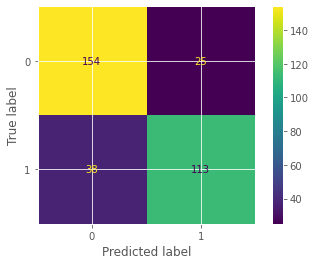

Neighbors: 20


              precision    recall  f1-score   support

           0       0.80      0.86      0.83       179
           1       0.82      0.75      0.78       151

    accuracy                           0.81       330
   macro avg       0.81      0.80      0.81       330
weighted avg       0.81      0.81      0.81       330



In [1246]:
X_train, X_test, y_train, y_test = train_test_split(X_undersampld_std, y_undersampled, test_size=0.33, random_state=42)

neighbors= 20
neigh= KNeighborsClassifier(n_neighbors= neighbors)
neigh.fit(X_train, y_train)
y_pred= neigh.predict(X_test) 

confusion_matrix(y_test, y_pred)
plot_confusion_matrix(neigh, X_test, y_test)  
plt.show()

print(f"Neighbors: {neighbors}\n\n")
print(classification_report(y_test, y_pred))


# -------------------------------------------------------------------------------------------

# 3. Decision Tree

In Decision tree we try to divide the data into segements which can act as a predictor of the output, in this case the feature `Churn`. Each segment is called a node, from those nodes we can make furthur segments extending the tree. wE can do this arbitrarily many times. That if we can keep adding more layers the data is getting segmentated more and more times. 

If we go to the extreme we can create one whole category for each data, **we van make the bias with the training data go 0. But it will lead to high variance, and won't generalize well with test data.**

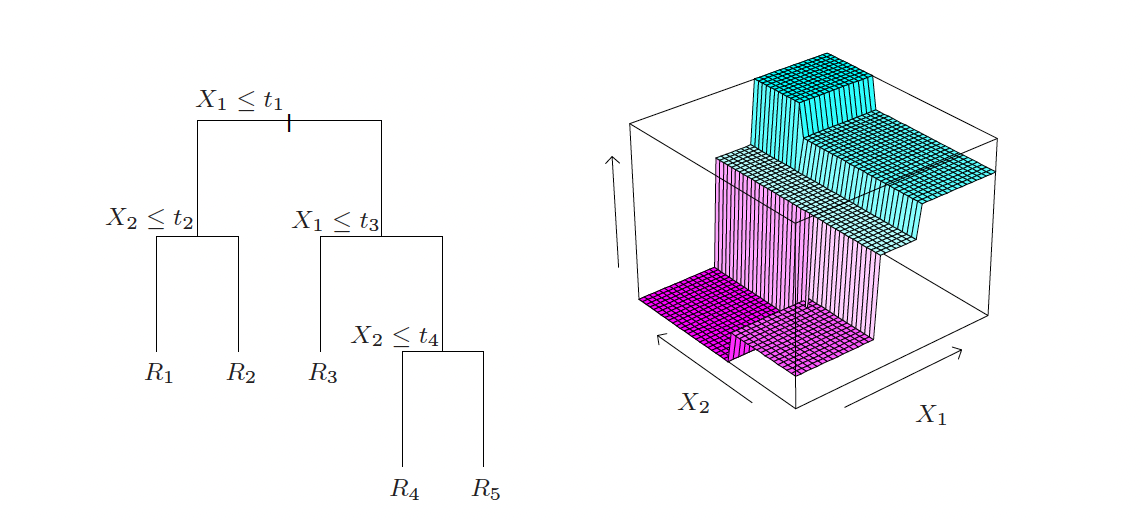

Here we can see the space is divided into regions, the datapoins are points in this space. In Decision Trees we basically segment this space using the training data, and use it as a predictor. SourceImage: *Elements of Statistical Learining, figure:9.2*

### Decision tress are prone to high variance problem, but has low bias. To deal with this issue we can do the two things, either we can put a restriction on the number of branches (restrict tree size)OR do Pruning.

### Tree size is a tuning parameter governing the model’s complexity, and the optimal tree size should be adaptively chosen from the data.

### We can restrict the size of the tree by putting a penalty on size of the tree. Thus we introduce an extra term in Loss Function 

$$ \propto \alpha|T|$$
$|T|$--> Size of the tree (the number of layers). Check *ESL: equation (9.16)*

### -WE WILL TRY TO VARY THE PARAMETERS $\alpha$ AND SEE FOR WHAT VALUES THE MODEL PREFORMS THE BEST.

### - WE WILL ALSO TRY OUT DIFFERENT  TYPES OF NODE IMPURITIES
- Gini impurity: $\sum f_i(1-f_i)$
- Entropy: $\sum_if_i\log f_i$
- Variance: $\frac{1}{N}\sum_i(y_i-\mu)^2$

$f_i$     <-- fraction of data points with class 0 output

$(1-f_i$) <-- fraction of data points with class 1 output
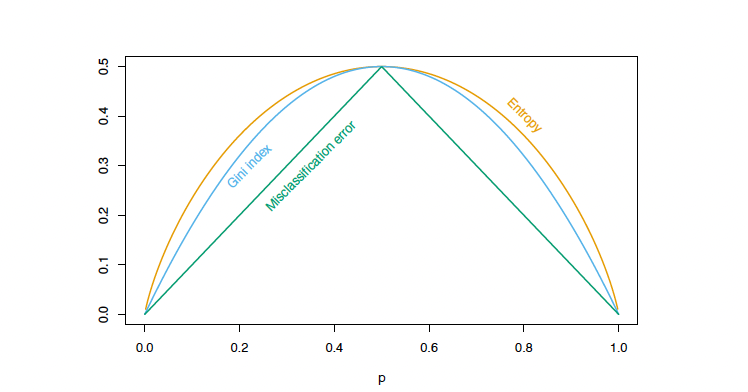

In [1247]:
#test-train split
X_train, X_test, y_train, y_test = train_test_split(X_undersampld_std, y_undersampled, test_size=0.33, random_state=42)
print('X_train Size:\t', X_train.shape)
print('y_train Size:\t', y_train.shape)
print('X_test Size:\t', X_test.shape)
print('y_test Size:\t', y_test.shape)

X_train Size:	 (670, 10)
y_train Size:	 (670,)
X_test Size:	 (330, 10)
y_test Size:	 (330,)


In [1248]:
dtree= DecisionTreeClassifier(criterion= 'gini')
dtree.fit(X_train, y_train)
y_pred= dtree.predict(X_test) 
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80       179
           1       0.76      0.76      0.76       151

    accuracy                           0.78       330
   macro avg       0.78      0.78      0.78       330
weighted avg       0.78      0.78      0.78       330



In [1249]:
dtree= DecisionTreeClassifier(criterion= 'entropy')
dtree.fit(X_train, y_train)
y_pred= dtree.predict(X_test) 
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.78      0.79       179
           1       0.74      0.77      0.76       151

    accuracy                           0.77       330
   macro avg       0.77      0.77      0.77       330
weighted avg       0.77      0.77      0.77       330



In [1250]:
dtree= DecisionTreeClassifier(criterion= 'log_loss')
dtree.fit(X_train, y_train)
y_pred= dtree.predict(X_test) 
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.81      0.81       179
           1       0.77      0.76      0.77       151

    accuracy                           0.79       330
   macro avg       0.79      0.79      0.79       330
weighted avg       0.79      0.79      0.79       330



### Entropy impurity performs the best!!

In [1251]:
dtree= DecisionTreeClassifier(criterion= 'entropy', splitter= "random")
dtree.fit(X_train, y_train)
y_pred= dtree.predict(X_test) 
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.81      0.81       179
           1       0.78      0.79      0.78       151

    accuracy                           0.80       330
   macro avg       0.80      0.80      0.80       330
weighted avg       0.80      0.80      0.80       330



### If we split randomly at each node, the model performs worse than if we made the best split at nodes. (Makes Sense) 

In [1252]:
dtree= DecisionTreeClassifier(criterion= 'entropy')
dtree.fit(X_train, y_train)
y_pred= dtree.predict(X_test) 
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.82      0.80       179
           1       0.77      0.74      0.76       151

    accuracy                           0.78       330
   macro avg       0.78      0.78      0.78       330
weighted avg       0.78      0.78      0.78       330



              precision    recall  f1-score   support

           0       0.87      0.74      0.80       179
           1       0.74      0.87      0.80       151

    accuracy                           0.80       330
   macro avg       0.80      0.81      0.80       330
weighted avg       0.81      0.80      0.80       330



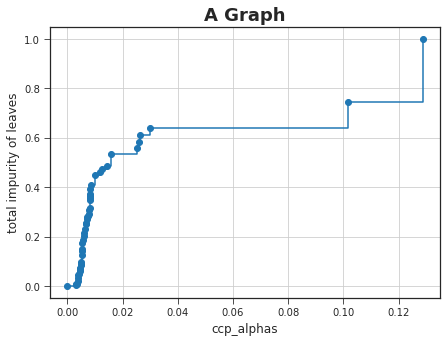

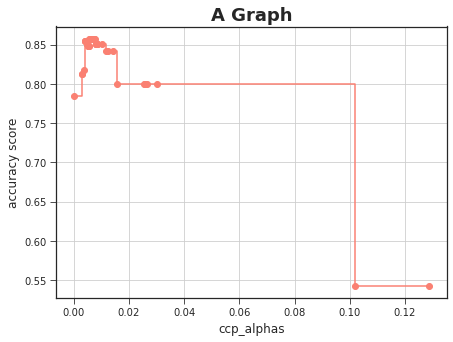

In [1253]:
#Fininding optimal value for ccp_alpha
dtree= DecisionTreeClassifier(criterion= 'entropy', ccp_alpha= 0.09)
dtree.fit(X_train, y_train)
y_pred= dtree.predict(X_test) 
path = dtree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print(classification_report(y_test, y_pred))
#print(ccp_alphas)
#print(impurities)
with plt.style.context(('seaborn-ticks')):
    plt.figure(figsize= (7,5))
    plt.plot(ccp_alphas, impurities, drawstyle="steps-post", marker='o', color= 'tab:blue')
    plt.xlabel("ccp_alphas")
    plt.ylabel("total impurity of leaves")
    plt.grid()
    plt.title("A Graph", weight= 'bold', size= 18)

clfs = []
for ccp_alpha in ccp_alphas:
    cls_tree = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    cls_tree.fit(X_train, y_train)
    clfs.append(cls_tree)

   
acc_score= []
for class_dtree in clfs:
    y_pred= class_dtree.predict(X_test)
    #print(accuracy_score(y_test, class_dtree.predict(X_test)))
    acc_score.append(accuracy_score(y_test, class_dtree.predict(X_test)))
    
with plt.style.context(('seaborn-ticks')):
    plt.figure(figsize= (7,5))
    plt.plot(ccp_alphas, acc_score, color= 'salmon', marker= 'o', drawstyle="steps-post")
    plt.xlabel("ccp_alphas")
    plt.ylabel("accuracy score")
    plt.grid()
    plt.title("A Graph", weight= 'bold', size= 18)

### There seems to be some issue on the above graph, impurity value cannot be more than 0.5. but here it is coming more than it. idk why

### From the accuracy_score vs ccp_alpha graph we can see, values of ccp_alphas ranging from 0.005 to 0.02 gives the best predictor of the data with accuracy of about 82-85%

In [1254]:
dtree= DecisionTreeClassifier(criterion= 'entropy', ccp_alpha= 0.01)
dtree.fit(X_train, y_train)
y_pred= dtree.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       179
           1       0.86      0.81      0.83       151

    accuracy                           0.85       330
   macro avg       0.85      0.85      0.85       330
weighted avg       0.85      0.85      0.85       330



### The above is the classification report for the decision tree with entopy impurity and cost complexity impurity value $\alpha$ = 0.01

In [1255]:
dtree= DecisionTreeClassifier(criterion= 'entropy', max_depth=5, min_samples_split=10)
dtree.fit(X_train, y_train)
y_pred= dtree.predict(X_test) 
path = dtree.cost_complexity_pruning_path(X_train, y_train)
print(classification_report(y_test, y_pred))
print(dtree.feature_importances_)

              precision    recall  f1-score   support

           0       0.82      0.89      0.85       179
           1       0.85      0.77      0.81       151

    accuracy                           0.84       330
   macro avg       0.84      0.83      0.83       330
weighted avg       0.84      0.84      0.84       330

[0.01234157 0.19968417 0.         0.02005242 0.22655318 0.316815
 0.02409942 0.06791653 0.07485808 0.05767963]


## Given below is the Confusion Matrix and Report for the best Decision Tree model along we found along w/ with the feature importance

/Users/ritobrotomohanta/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


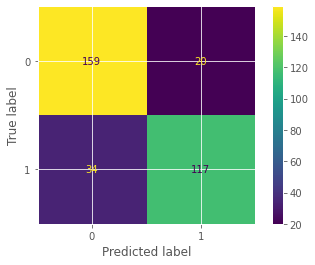

              precision    recall  f1-score   support

           0       0.82      0.89      0.85       179
           1       0.85      0.77      0.81       151

    accuracy                           0.84       330
   macro avg       0.84      0.83      0.83       330
weighted avg       0.84      0.84      0.84       330



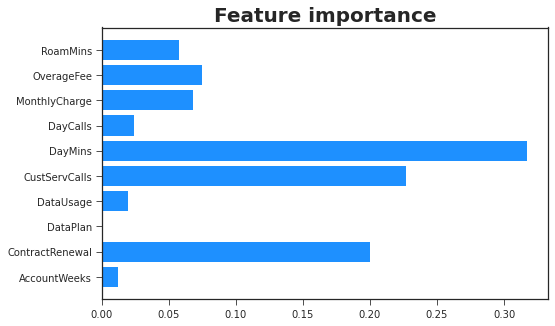

In [1256]:
X_train, X_test, y_train, y_test = train_test_split(X_undersampld_std, y_undersampled, test_size=0.33, random_state=42)

dtree= DecisionTreeClassifier(criterion= 'entropy', max_depth=5, min_samples_split=10)
dtree.fit(X_train, y_train)
y_pred= dtree.predict(X_test) 

confusion_matrix(y_test, y_pred)
plot_confusion_matrix(dtree, X_test, y_test)  
plt.show()

print(classification_report(y_test, y_pred))
#print(dtree.feature_importances_)
#print(dtree.feature_names_in_)
with plt.style.context(('seaborn-ticks')):
    plt.figure(figsize= (8,5))
    plt.barh(dtree.feature_names_in_, dtree.feature_importances_, color= 'dodgerblue')
    plt.title("Feature importance", weight= 'bold', size= 20)

### One weird thing that is observed here is the importance of `DataPlan` is 0. From the Data Analysis part it was observed that DataPlan should be a significant predictor of `Churn`.. But from here we can see that DataPlan coefficient is 0. Or maybe the visuals are misleading.

### Other than that we observe `DayMins` - average daytime minutes per month has the highest influence on `Churn`  (if customer cancelled service)

### Followed by `ContractRenewal`, then followed by `CusrServCalls`. Which we also confirm visually from the data form the data analysis part

# -------------------------------------------------------------------------------------------

# 4. Random Forest

In Random Forest algorithm we create multiple bootstrap samples of the training data and on each bootstrap sample we choose m (<<p) features randomly and fit CART on it. When making prediction, we assign predicted value as the majority of the votes assigned to the data from each of the bootstrapped data.

In the case of bagged trees, the mean is same as the mean of the individual tree. The aim of Random Forest is to somehow reduce the variance.

Variance of the average
$$ = \rho \sigma^2 + \frac{1-\rho}{B}\sigma^2 $$

$\rho$ <-- pairwise correlation

$B$ <-- number of bootstrapped samples

$\sigma$ <-- variance

We can see from the above equation as we take large number of bootstrapped samples ($B$) the second term goes to zero. But for the first term if we only take m (<<p) features instead of all features p, the pairwise correation $\rho$ is lower. Thus reducing overall variance of the average.

#### Link- https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm#varimp

In [1257]:
X_train, X_test, y_train, y_test = train_test_split(X_undersampld_std, y_undersampled, test_size=0.33, random_state=42)
randomforset= RandomForestClassifier()
randomforset.fit(X_train, y_train)
y_pred= randomforset.predict(X_test) 
print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

           0       0.87      0.87      0.87       179
           1       0.84      0.84      0.84       151

    accuracy                           0.85       330
   macro avg       0.85      0.85      0.85       330
weighted avg       0.85      0.85      0.85       330



In [1258]:
X_train, X_test, y_train, y_test = train_test_split(X_undersampld_std, y_undersampled, test_size=0.33, random_state=42)
randomforset= RandomForestClassifier(criterion='entropy')
randomforset.fit(X_train, y_train)
y_pred= randomforset.predict(X_test) 
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.89      0.88       179
           1       0.86      0.83      0.85       151

    accuracy                           0.86       330
   macro avg       0.86      0.86      0.86       330
weighted avg       0.86      0.86      0.86       330



In [1270]:
X_train, X_test, y_train, y_test = train_test_split(X_undersampld_std, y_undersampled, test_size=0.33, random_state=42)
randomforset= RandomForestClassifier(criterion='entropy', n_estimators= 40)
randomforset.fit(X_train, y_train)
y_pred= randomforset.predict(X_test) 
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.89      0.87       179
           1       0.87      0.82      0.84       151

    accuracy                           0.86       330
   macro avg       0.86      0.86      0.86       330
weighted avg       0.86      0.86      0.86       330



### Below is the BEST MODEL among all Random Forest!

              precision    recall  f1-score   support

           0       0.87      0.89      0.88       179
           1       0.86      0.85      0.86       151

    accuracy                           0.87       330
   macro avg       0.87      0.87      0.87       330
weighted avg       0.87      0.87      0.87       330



/Users/ritobrotomohanta/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


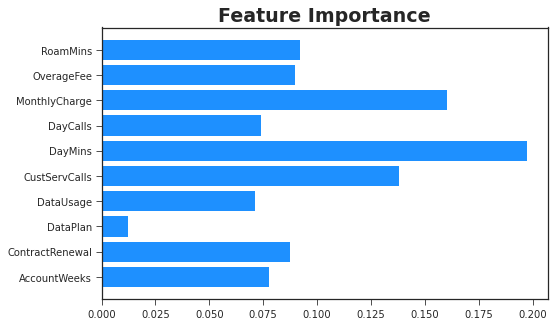

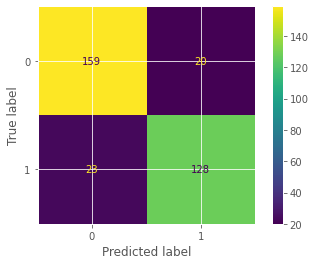

Accuracy: 0.8696969696969697


In [1292]:
X_train, X_test, y_train, y_test = train_test_split(X_undersampld_std, y_undersampled, test_size=0.33, random_state=42)
randomforset= RandomForestClassifier(criterion='entropy', n_estimators= 40, oob_score= True)
randomforset.fit(X_train, y_train)
y_pred= randomforset.predict(X_test) 
print(classification_report(y_test, y_pred))

randomforset.feature_importances_
with plt.style.context(('seaborn-ticks')):
    plt.figure(figsize= (8,5))
    plt.barh(randomforset.feature_names_in_, randomforset.feature_importances_, color= 'dodgerblue')
    plt.title("Feature Importance", weight= 'bold', size= 19)
    
confusion_matrix(y_test, y_pred)
plot_confusion_matrix(randomforset, X_test, y_test)  
plt.show()
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

# From all the models we tried, Random Forest works the best. WITH ACCURACY ~ 86.4%

1. Who are the customers more likely to churn?
2. What are the relations between some of the variables.!
3. What actions can be taken to stop them from leaving?

## 1. From the models we see DayMins plays one of the most important role in predicting Churn. Therefore if we look at the graph we can conclude a customer having more than 250mins of call per month has a increases the probability of their Churning significalntly. This is followed by Monthly Charge.

## 2. Shown in the anlysis part.

## 3. From the analysis part we have seen that those customers without Data Plan, DayMins and Monthly Charges forms a very good predictor of Churning (Very high density churning cases for DayMins > 250 && MonthlyCharge > 60). So we can try to decrease the Monthly Charges rate, I would predict Churining might decrease.

## Also I would also suggest that when a same customer has multiple calls to the customer care, there should be extra care given to the customer so that their issue is fixed. More than 4 customer service calls forms a good predictor of Churn.

# ----------------------------------  THE END   -------------------------------------------